### Requirements

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 8.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910460 sha256=f43d640ba6970729d78d4348af26c89730d93d21bdff95b815fd17781d34917c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


### Libraries

In [ ]:
import torch
import torch.nn as nn
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
import numpy as np
import random
import networkx as nx
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, accuracy_score

### Load Dataset

In [ ]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

Processing...
Done!


### Encoder

In [ ]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

### Decoder

In [ ]:
class TriadDecoder(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(TriadDecoder, self).__init__()

        # 1x1 convolution
        self.conv = nn.Conv1d(in_channels, hidden_channels, kernel_size=1)

        # Fully connected
        self.fc = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, triad):

        # Input embeddings
        u, v, w = triad
        x1, x2, x3 = x[u], x[v], x[w]

        # 1x1 convolution
        z1 = self.conv(x1.unsqueeze(-1)).relu()
        z2 = self.conv(x2.unsqueeze(-1)).relu()
        z3 = self.conv(x3.unsqueeze(-1)).relu()

        # Fully connected
        z1 = self.fc(z1.squeeze(-1)).relu()
        z2 = self.fc(z2.squeeze(-1)).relu()
        z3 = self.fc(z3.squeeze(-1)).relu()

        # Merge
        z_triplet = z1 + z2 + z3

        #print(x1.shape)
        #print(x2.shape)
        #print(z_triplet.shape)
        # Inner product
        e1 = torch.dot(x1,x2)
        e2 = torch.dot(x1,x3)
        e3 = torch.dot(x2,x3)
        sum = [e1, e2, e3]
        sum = torch.FloatTensor(sum)



        y = sum + z_triplet
        y = torch.softmax(y, dim=0)

        return y

### Sample triad

In [ ]:
# Get graph neighbors
def neighbors(node):
  return np.where(A[node]==1)[0]

def sample_triad(A,p):
    """
    Sample triad from adjacency matrix A
    """

    nodes = list(range(A.shape[0]))

    # Sample node
    i = random.choice(nodes)

    if random.random() < p:
        j = random.choice(neighbors(i))
    else:

        j = random.choice(nodes)
        while(j==i):
          j = random.choice(nodes)

    # Sample k
    if random.random() < p:
        k = random.choice(neighbors(j))
    else:
        k = random.choice(nodes)
        while(k==i or k==j):
          k = random.choice(nodes)

    return (i, j, k)

### Training

In [ ]:
def reconstruction_loss(pred, A, triad):
    """
    Calculate reconstruction loss for a triad prediction
    """
    i, j, k = triad

    # Predicted edge probabilities
    p_ij, p_ik, p_jk = pred

    # Actual edge values
    a_ij = A[i, j]
    a_ik = A[i, k]
    a_jk = A[j, k]

    # Loss
    loss = - (a_ij * torch.log(p_ij) +
              (1 - a_ij) * torch.log(1 - p_ij) +
              a_ik * torch.log(p_ik) +
              (1 - a_ik) * torch.log(1 - p_ik) +
              a_jk * torch.log(p_jk) +
              (1 - a_jk) * torch.log(1 - p_jk))

    return loss

In [ ]:
# Get networkx graph from PyG graph data
G = nx.from_edgelist(data.edge_index.T.tolist())

# Compute adjacency matrix
A = nx.to_numpy_array(G)
A.shape

(2708, 2708)

In [ ]:
encoder = GCNEncoder(dataset.num_features, 16, 32)
decoder = TriadDecoder(32, 3)
# Optimizer
learning_rate = 0.001


encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)

best_enc= -1
best_dec = -1
best_loss = 10000000

# Optimizer
model = nn.Sequential(encoder, decoder)
opt = optim.Adam(model.parameters(), lr=0.001)
loss_total=[]

for epoch in range(1000):
    #opt.zero_grad()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Sample triad
    i, j, k = sample_triad(A,0.5)
    triad = [i, j, k]

    # Encode
    x = encoder(data.x, data.edge_index)

    # Decode
    y = decoder(x, triad)

    # Loss (eq 7)
    loss = reconstruction_loss(y, A, triad)
    l = loss.item()
    if(l<best_loss):
      best_loss = l
      best_enc= encoder
      best_dec = decoder

    # Print
    print(f'Epoch {epoch}: Loss = {l:.4f}')
    loss_total.append(l)


    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    #opt.step()

Epoch 0: Loss = 3.1853
Epoch 1: Loss = 3.1338
Epoch 2: Loss = 1.2763
Epoch 3: Loss = 1.6603
Epoch 4: Loss = 1.2780
Epoch 5: Loss = 1.5456
Epoch 6: Loss = 1.2785
Epoch 7: Loss = 1.2796
Epoch 8: Loss = 3.6657
Epoch 9: Loss = 3.3016
Epoch 10: Loss = 1.2819
Epoch 11: Loss = 3.1350
Epoch 12: Loss = 1.4584
Epoch 13: Loss = 1.2843
Epoch 14: Loss = 1.2894
Epoch 15: Loss = 1.3313
Epoch 16: Loss = 1.3236
Epoch 17: Loss = 3.0746
Epoch 18: Loss = 3.0843
Epoch 19: Loss = 1.3870
Epoch 20: Loss = 1.3161
Epoch 21: Loss = 3.0367
Epoch 22: Loss = 3.0805
Epoch 23: Loss = 2.8718
Epoch 24: Loss = 2.9761
Epoch 25: Loss = 1.3421
Epoch 26: Loss = 0.8082
Epoch 27: Loss = 1.1249
Epoch 28: Loss = 3.0470
Epoch 29: Loss = 1.4309
Epoch 30: Loss = 3.1165
Epoch 31: Loss = 2.7855
Epoch 32: Loss = 3.3764
Epoch 33: Loss = 3.3068
Epoch 34: Loss = 2.8270
Epoch 35: Loss = 2.7200
Epoch 36: Loss = 3.0782
Epoch 37: Loss = 2.7826
Epoch 38: Loss = 0.9867
Epoch 39: Loss = 1.3511
Epoch 40: Loss = 0.9929
Epoch 41: Loss = 1.3180
Ep

In [ ]:
best_loss

0.3474699854850769

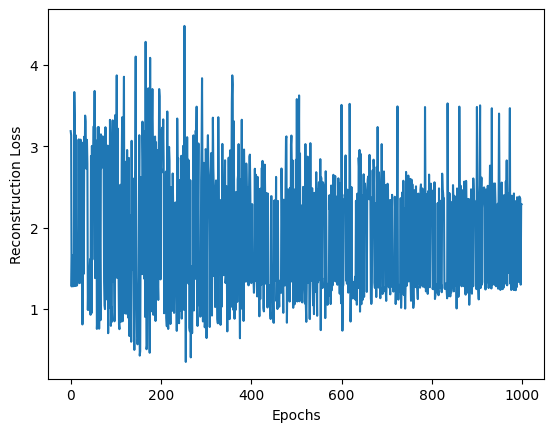

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_total)
plt.ylabel('Reconstruction Loss')
plt.xlabel('Epochs')
plt.show()

### Clustring

In [ ]:

# Get node embeddings
embeddings = best_enc(data.x, data.edge_index)
num_classes =7

# Cluster using k-means
kmeans = KMeans(n_clusters=num_classes)
emb_np = embeddings.detach().numpy()
pred = kmeans.fit_predict(emb_np)

# Evaluate clustering


nmi = normalized_mutual_info_score(data.y, pred)
acc = accuracy_score(data.y, pred)

print(f'NMI: {nmi:.4f}, Accuracy: {acc:.4f}')

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


NMI: 0.0403, Accuracy: 0.2024


In [ ]:
torch.save(best_enc, 'encoder.pth')

### Training with Mini-batche

In [ ]:
from tqdm import tqdm
# Generate batches
def generate_triad_batches(A, batch_size=32):
  # Total number of optimization steps
  steps = 10

  # Samples per epoch
  num_samples = 100

  # Batches per epoch
  num_batches = num_samples // batch_size

  # Total batches to generate
  num_batches = steps * num_batches

  batches = []
  for i in tqdm(range(num_batches)):

    batch = []
    for _ in range(batch_size):
      triad = sample_triad(A)
      batch.append(triad)

    batches.append(batch)

  return batches

In [ ]:
# Generate triad batches
triad_batches = generate_triad_batches(A)

100%|██████████| 30/30 [00:00<00:00, 546.92it/s]


In [ ]:
import torch.optim as optim
from statistics import mean

# Models
encoder = GCNEncoder(dataset.num_features, 16, 32)
decoder = TriadDecoder(32, 3)

# Optimizers
encoder_opt = optim.Adam(encoder.parameters(), lr=0.001)
decoder_opt = optim.Adam(decoder.parameters(), lr=0.001)


for epoch in range(100):
  total_loss = []

  for batch in tqdm(triad_batches):

    for triad in batch:
      x = encoder(data.x, data.edge_index)
      y = decoder(x, triad)
      loss = reconstruction_loss(y, A, triad)
      l=loss.item()
      total_loss.append(l)
      loss.backward()
      encoder_opt.step()
      decoder_opt.step()

  print(f'Epoch {epoch}: Loss = {mean(total_loss):.4f}')



100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Epoch 0: Loss = nan


 60%|██████    | 18/30 [00:10<00:06,  1.79it/s]


KeyboardInterrupt: ignored